# Visualizing Arctic Cloud Anomaly With CMIP6 Data

#### Requirements: 
- Python (Anaconda recommended)
- IDE / Text editor that can handle Jupyter Notebooks
- Packages:
    - zarr
    - numpy
    - pandas
    - fsspec
    - matplotlib
    - xarray
    - gcsfs
    - tqdm
    - cartopy
    - iris
    - seaborn
- System:
    - Tested on Windows but should work on Linux, too

#### Other:
Please note that the program takes some time to run depending on how much data there is. \
The longest function has a progress bar to help visualize progress.
    

In [26]:
import zarr
import numpy as np
import pandas as pd
import fsspec
import matplotlib.pyplot as plt
import xarray as xa
from datetime import datetime as dt
import warnings
from tqdm.notebook import tqdm
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import seaborn as sns
import matplotlib.path as mpath
import iris
import cartopy

In [2]:
#disabling warnings
warnings.simplefilter("ignore")

In [3]:
#reading a list of CMIP experiments
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [4]:
#variable (examples: low = cllcalipso, mid = clmcalipso, high = clhcalipso)
var = "cllcalipso"
#time pediod (Y,M,D)
db1 = dt(1985,1,1)
de1 = dt(2014,12,31)

db2 = dt(2015,1,1)
de2 = dt(2100,12,31)
#experiment
ex1 = "historical"
ex2 = "ssp245"
#max number of datasets
md = 10

In [9]:
#find the unique sources while keeping the order
def unique(sequence):
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

In [10]:
#load datasets from chosen sources
def get_datasets(variable : str, sources : list, experiment : str) -> list:
    ds_list = []
    for source in sources:
        result = df.query(f"variable_id == '{variable}' & experiment_id == '{experiment}' & source_id == '{source}'")
        #open dataset
        ds = xa.open_zarr(fsspec.get_mapper(result.zstore.values[0]), consolidated=True, decode_times=False)
        #some coordinates are inconsistent and it's easiest to ignore them
        if "lat" in ds[variable].dims and len(ds[variable]["time"]) < 10000:
            ds_list.append(ds)
        #limit the number of datasets
        if len(ds_list) >= md:
            break
    return ds_list  

In [13]:
#groups Xarray datasets as Pandas DataFrames
def group(ds : xa.Dataset, variable : str) -> xa.Dataset:
    #grouping is more efficient with Pandas DataFrames
    df_h = ds[variable].to_dataframe()
    df_h = df_h.reset_index()
    #regroup by years and months
    dff = df_h.groupby([df_h.time.dt.year, df_h.time.dt.month, "lat", "lon"])[[variable]].mean()
    dff.index.names = ["Years", "Months", "lat", "lon"]
    ds = dff.to_xarray()
    return ds

In [12]:
def process_datasets(datasets : list, variable : str, db : dt, de : dt, ref) -> tuple:
    processed = []
    mean_list = []
    #reference to use in regridding
    if ref is None:
        ref = datasets[0][variable].to_iris()
    elif type(ref) == tuple:
        ref = ref[0]
    #progressbar for visualization
    with tqdm(total=len(datasets), colour="green") as pbar:
        pbar.set_description("Processing given datasets")
        for dataset in datasets:
            #reformat time
            try:
                #times that are expressed as "x since" need to be changed
                if " ".join(dataset["time"].units.split(" ")[0:2]) == 'hours since': 
                    start = dataset["time"].units.split(" ")[2]   
                    dataset["time"] = dataset["time"]/24
                else:
                    start = dataset["time"].units.split(" ")[2]
                try:
                    #timestamp needs to be possible to be created
                    pd.Timestamp(start)
                except:
                    continue
                dataset["time"] = pd.to_datetime(dataset["time"], unit='D',
                origin=pd.Timestamp(start))
            except:
                #if time is already in xx:xx:xxxx or similar
                pass
            #all date formats to datetime
            dataset["time"] = dataset["time"].astype("datetime64[ns]")
            #regid to ref
            dataset = dataset[variable].to_iris()
            dataset = dataset.regrid(ref, iris.analysis.Linear())
            dataset = xa.DataArray.from_iris(dataset)
            dataset = dataset.to_dataset()
            #spatial limits (Artic area -> 66.5-90 N)
            min_lat = dataset.sel(lat=66.5, method="nearest").lat.values
            dataset = dataset.sel(lat=slice(min_lat,90))
            #temporal limits, mean: reference period from 1850 to 1900, dataset: data from wanted time period
            mean = dataset.sel(time=slice(dt(1850,1,1),dt(1900,1,31)))
            dataset = dataset.sel(time=slice(db,de))
            ds = group(dataset, variable)
            ds_mean = group(mean, variable)
            processed.append(ds)
            mean_list.append(ds_mean)
            pbar.update(1)
    #ref is returned so that it can be used again with other experiments
    return processed, mean_list, ref

In [14]:
#helper function, uses the above functions and concatenates models together
def execute(variable : str, experiment : str, db : dt, de : dt, ref=None) -> tuple:
    #initial results with duplicate sources
    init = df.query(f"variable_id == '{variable}' & experiment_id == '{experiment}'")
    #unique source list
    sources = unique(init.source_id)
    #list of datasets
    dset_list = get_datasets(variable, sources, experiment)
    #not all sources are necessarily used so the sources are updateted
    sources = [ds.source_id for ds in dset_list]
    #processing the datasets
    pros, mean_list, ref = process_datasets(dset_list, variable, db, de, ref)
    #average : data from chosen period from all models
    #ref_period : reference period of 1850-1900 from all models
    average = xa.concat(pros, pd.Index(sources, name="source_id"), coords='minimal').mean('source_id')[variable].fillna(0)
    ref_period  = xa.concat(mean_list, pd.Index(sources, name="source_id"), coords='minimal').mean('source_id')[variable].fillna(0)
    return average, ref_period, ref

In [23]:
#historical data
ave1, ref1, ref = execute(var, ex1, db1, de1)

  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
#ssp245
ave2, ref2, ref = execute(var, ex2, db2, de2, ref)

  0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
def multi_apply_along_axis(func1d, axis, arrs, *args, **kwargs):
    #Source : https://climate-cms.org/posts/2019-07-29-multi-apply-along-axis.html#scott-wales-clex-cms
    """
    Given a function `func1d(A, B, C, ..., *args, **kwargs)`  that acts on 
    multiple one dimensional arrays, apply that function to the N-dimensional
    arrays listed by `arrs` along axis `axis`
    
    If `arrs` are one dimensional this is equivalent to::
    
        func1d(*arrs, *args, **kwargs)
    
    If there is only one array in `arrs` this is equivalent to::
    
        numpy.apply_along_axis(func1d, axis, arrs[0], *args, **kwargs)
        
    All arrays in `arrs` must have compatible dimensions to be able to run
    `numpy.concatenate(arrs, axis)`
    
    Arguments:
        func1d:   Function that operates on `len(arrs)` 1 dimensional arrays,
                  with signature `f(*arrs, *args, **kwargs)`
        axis:     Axis of all `arrs` to apply the function along
        arrs:     Iterable of numpy arrays
        *args:    Passed to func1d after array arguments
        **kwargs: Passed to func1d as keyword arguments
    """
    # Concatenate the input arrays along the calculation axis to make one big
    # array that can be passed in to `apply_along_axis`
    carrs = np.concatenate(arrs, axis)
    
    # We'll need to split the concatenated arrays up before we apply `func1d`,
    # here's the offsets to split them back into the originals
    offsets=[]
    start=0
    for i in range(len(arrs)-1):
        start += arrs[i].shape[axis]
        offsets.append(start)
            
    # The helper closure splits up the concatenated array back into the components of `arrs`
    # and then runs `func1d` on them
    def helperfunc(a, *args, **kwargs):
        arrs = np.split(a, offsets)
        return func1d(*[*arrs, *args], **kwargs)
    
    # Run `apply_along_axis` along the concatenated array
    return np.apply_along_axis(helperfunc, axis, carrs, *args, **kwargs)

In [24]:
ds_list = []
#reference period
ref = ref1.mean("Months").mean("Years")
#calculate the anomalies
for i in range(len(ave1.Years)):
    #anomaly for each year, historical
    a = ave1.isel(Years=i)-ref
    ds_list.append(a)
for i in range(len(ave2.Years)):
    #anomaly for each year, ssp245
    a = ave2.isel(Years=i)-ref
    ds_list.append(a)

Text(0.5, 0.98, 'Low Cloud Fraction anomaly 1985-2100 (ref. period 1850-1900)')

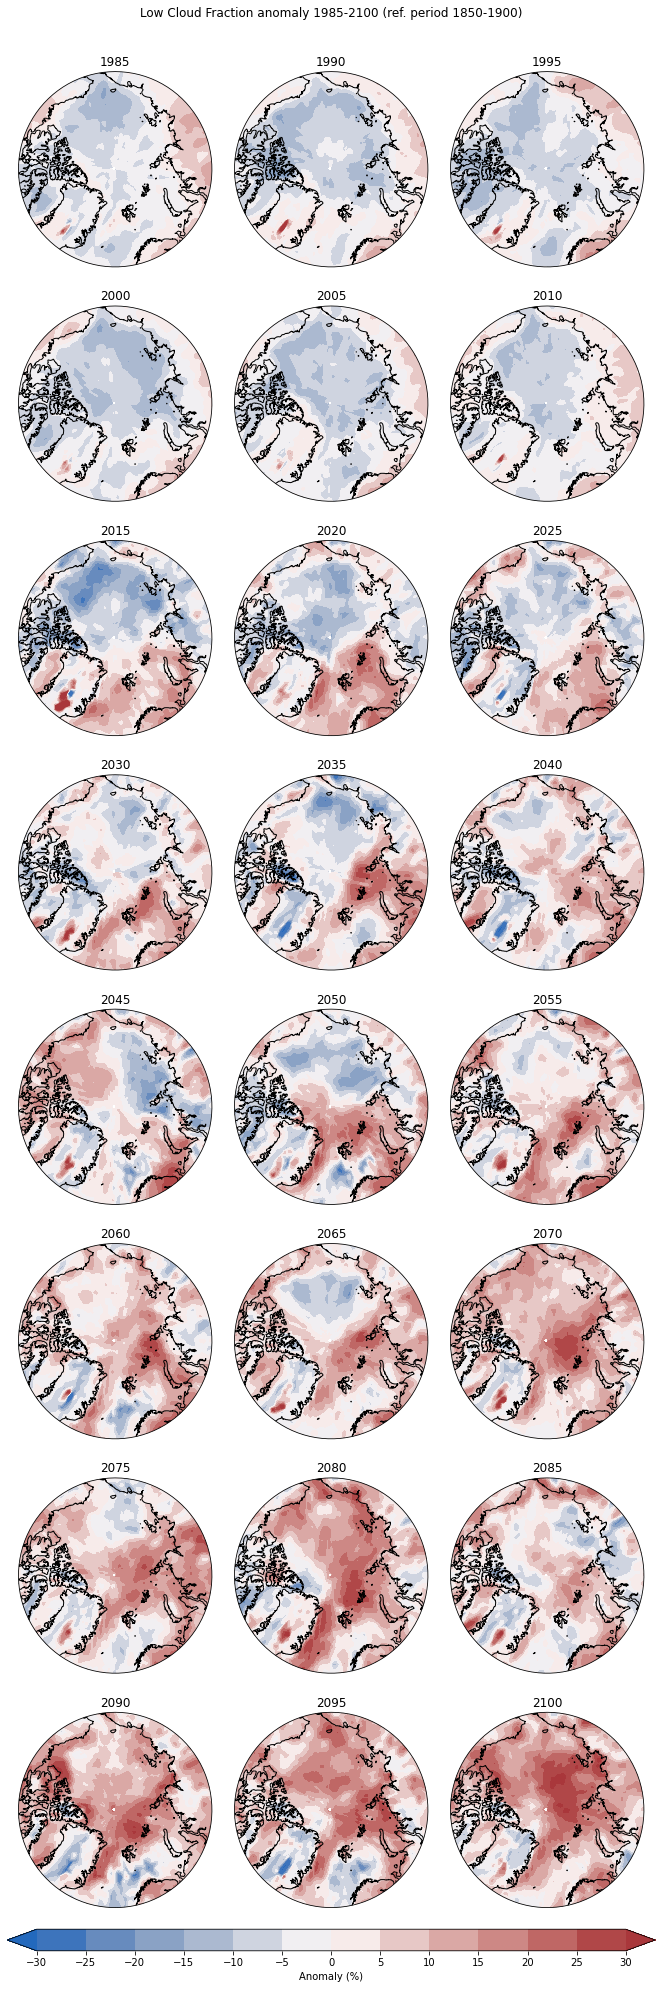

In [25]:
#define the contour levels to use in plt.contourf
clevs=np.arange(-30,35,5)

#titles, 5 year interval
years = (list(ave1.Years.values)+list(ave2.Years.values))[::5]

#figure, subplots, projection
fig, axs = plt.subplots(nrows=8,ncols=3,
                        subplot_kw={'projection': ccrs.NorthPolarStereo()},
                        figsize=(30,30))

#flatten axes to 1D
axs=axs.flatten()
#looping over years
for i, model in enumerate(ds_list[::5]):

        #data for the year
        data=model[0,:,:]
        #colormap
        cmap = sns.color_palette("vlag", as_cmap=True)
        #connecting the sides together
        data, lons = add_cyclic_point(data, coord=a["lon"])
        #filled contourmap
        cs = axs[i].contourf(lons, a['lat'], data, clevs, transform=ccrs.PlateCarree(),cmap=cmap, extend="both")
        #limit the area
        axs[i].set_extent((0,361,66.5,90),crs=ccrs.PlateCarree())
        #turn maps into circles
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5,0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        axs[i].set_boundary(circle, transform=axs[i].transAxes)

        #title for each subplot
        axs[i].set_title(years[i])

        #coastlines
        axs[i].coastlines()
        #fill land
        #axs[i].add_feature(cartopy.feature.LAND, facecolor='white', zorder=1)
#adjust sublot sizes and location
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.35, right=0.65, wspace=0, hspace=0.2)
#axis for colorbar
cbar_ax = fig.add_axes([0.35, 0.08, 0.3, 0.01])
#colorbar, ticks from clev
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal', ticks=clevs)
#colorbar title
cbar_ax.set_xlabel("Anomaly (%)")
#title for the whole plot
plt.suptitle(f'Low Cloud Fraction anomaly {db1.year}-{de2.year} (ref. period 1850-1900)')